Importing necessary libraries

In [1]:
# install suprise package in case it is not installed in your system by uncommentning the below.
!pip install scikit-surprise

     |████████████████████████████████| 11.8 MB 7.1 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1623224 sha256=7cefc2ec197f8f16bc5dc94546b97796a138ac0f62a77f9a8b7d3764b3dc1a00
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [2]:
# Load the file directory here. Please update the file path as per your file location in the google drive.
# For me the datasetB.json file was kept within datasets directory in my Google drive so below was my file path.

FilePath = "/content/drive/My Drive/datasets/datasetB.json"

Importing the necessary libraries hereby.

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import TruncatedSVD
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from itertools import compress
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from surprise import Dataset


import warnings; warnings.simplefilter('ignore')

In [4]:
# If you wish to load the json file from google drive then you need to mount the Google drive with the below code first.

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Now we write two functions which we will make use of to extract the data from the large json file. The json file has 3 objects in it named Patients, Conditions and Therapies. The below function "Extract_dataframe_from_json" helps us extract the data within the Patients object as pandas dataframe and the next function, "Extract_Therapies" helps us fetch the data stored within the json object named Therapies in the form of pandas DataFrame.

In [5]:
# Below are the function definitions to get data from json dataset into pandas DataFrame.

# In order to extract necessary Patient information 
def Extract_dataframe_from_json(filename):
    with open(filename) as jsonFile:
        data = json.load(jsonFile)

    df_trials = pd.json_normalize(data['Patients'], "trials", ["id", "name"], errors='ignore', record_prefix='_')

    df_conditions = pd.json_normalize(data['Patients'], "conditions", ["id", "name"], errors='ignore', record_prefix='_')

    patients = pd.DataFrame(data['Patients'])[["id", "gender", "age", "blood_group"]]

    patients = patients.merge(df_conditions, how="inner", left_on=['id'], right_on=["id"])

    patients = patients.rename({'_id': '_condition'}, axis='columns')

    patients = patients.merge(df_trials, how="left", on=['id','_condition', 'name'])

    patients = patients.drop(columns=["_end", "_start", "_id"])
    patients = patients.fillna(0)
    return patients

# In order to extract necessary Therapies information 
def Extract_Therapies(filename):
    with open(filename) as jsonFile:
        data = json.load(jsonFile)
    Therapies = pd.DataFrame(data["Therapies"])
    return Therapies


In [6]:
# Importing the patient information using the function defined previously

ff = Extract_dataframe_from_json(FilePath)
df = ff.copy()
ff.head(3)

,id,gender,age,blood_group,_cured,_diagnosed,_condition,_isCured,_isTreated,_kind,name,_successful,_therapy
0,0,male,57,O+,Null,20080609,pc1,False,False,Cond46,Thomas Oswalt,0.0,0
1,0,male,57,O+,Null,20131212,pc2,False,False,Cond171,Thomas Oswalt,0.0,0
2,0,male,57,O+,20120404,20111218,pc3,True,True,Cond240,Thomas Oswalt,86.0,Th49


In [7]:
# Taking required columns and making a separate dataframe for ease
ff2 = ff[['id', '_kind','gender', 'age', 'blood_group', '_isCured', '_isTreated']]

#Converting the id and age column to int type
ff2[["id"]] = ff2[["id"]].astype(int)
ff2[["age"]] = ff2[["age"]].astype(int)

# Performing Ordinal encoding so that we can implement ML algorithms better
ord_enc = OrdinalEncoder()
ff2["blood_group_code"] = ord_enc.fit_transform(ff2[["blood_group"]])
ff2["gender_code"] = ord_enc.fit_transform(ff2[["gender"]])
ff2["Cured_code"] = ord_enc.fit_transform(ff2[["_isCured"]])
ff2["kind_code"] = ord_enc.fit_transform(ff2[["_kind"]])
ff2["isTreated_code"] = ord_enc.fit_transform(ff2[["_isTreated"]])

# Droppin the categorical columns which are no longer needed
ff2 = ff2.drop(columns = ["_isCured", "_kind", "gender","blood_group", "_isTreated"])
ff2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1047880 entries, 0 to 1047879
Data columns (total 7 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   id                1047880 non-null  int64  
 1   age               1047880 non-null  int64  
 2   blood_group_code  1047880 non-null  float64
 3   gender_code       1047880 non-null  float64
 4   Cured_code        1047880 non-null  float64
 5   kind_code         1047880 non-null  float64
 6   isTreated_code    1047880 non-null  float64
dtypes: float64(5), int64(2)
memory usage: 64.0 MB


### We have tried implementing both **Content Based Recommendation** and **Collaborative filtering**. First we build the recommender system using content based system below.

# 1. Content Based Recommender System

Here we will try implementing the Content Based Recommender.
<br>We try to do clustering of the data first. As we get the clusters with similar entries in each clusters we find the therapies among those clusters based on the patient condition and recommend the therapy which has the highest success rate.

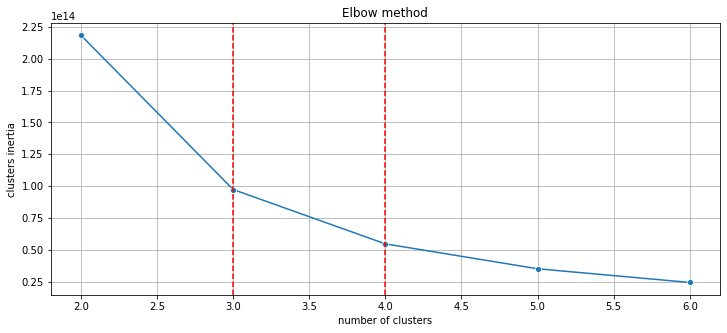

In [8]:
# Converting dataframe to numpy array for clustering
X = np.array(ff2)

# We try running the clustering algorithm over 5 cluster numbers
# in order to perform hyper parameter tuning. 

n_clusters = [2,3,4,5,6] # number of clusters
clusters_inertia = [] # inertia of clusters

# implementing K Means Clustering 
for n in n_clusters:
    KM_est = KMeans(n_clusters=n, init='k-means++').fit(X)
    clusters_inertia.append(KM_est.inertia_)    # data for the elbow method

# Plot for elbow method to find the optimum value of n_clusters
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(n_clusters, clusters_inertia, marker='o', ax=ax)
ax.set_title("Elbow method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("clusters inertia")
ax.axvline(3, ls="--", c="red")
ax.axvline(4, ls="--", c="red")
plt.grid()
plt.show()

In [9]:
# From the elbow method we got to know that n_clusters of 4 is the optimum
# implemented the algorithm
KM_3_clusters = KMeans(n_clusters=4 , random_state=40, init='k-means++').fit(X)

df["ClusterNo"] = pd.DataFrame(KM_3_clusters.fit_predict(X))

# Now that the clustering is done we store each cluster in separate dataframes for ease.
df0 = df[df["ClusterNo"] == 0].reset_index(drop=True)
df1 = df[df["ClusterNo"] == 1].reset_index(drop=True)
df2 = df[df["ClusterNo"] == 2].reset_index(drop=True)
df3 = df[df["ClusterNo"] == 3].reset_index(drop=True)

df.head(2)

,id,gender,age,blood_group,_cured,_diagnosed,_condition,_isCured,_isTreated,_kind,name,_successful,_therapy,ClusterNo
0,0,male,57,O+,Null,20080609,pc1,False,False,Cond46,Thomas Oswalt,0.0,0,0
1,0,male,57,O+,Null,20131212,pc2,False,False,Cond171,Thomas Oswalt,0.0,0,0


<br>

### **Here we enter the values of Patient Id and Patient Condition** by passing the values to the below two variables named PatientID & PatCond respectively.

In [10]:
# Enter the Patient ID and the Patient Condition you want to test in order to come up with a therapy recommendation

PatientID = 51453
PatCond = "pc278191"

# PatientID = input("Enter the patient ID : ")
# PatCond = input("Enter the patient condition ID : ")

The below function uses clustering to come up with Therapy recommendation. 

In [11]:
def ContentBased_Recommender(PatientID, PatCond):
  if any(df0["id"] == int(PatientID)) and any(df0["_condition"] == str(PatCond)):
    p = df0[df0["id"] == int(PatientID)][["_kind", "_therapy", "_successful"]][df0["_condition"] == str(PatCond)]
    return (p.sort_values(by = ["_successful", "_therapy","_kind"], ascending=False)["_therapy"].iloc[0])
    
  elif any(df1["id"] == int(PatientID)) and any(df1["_condition"] == str(PatCond)):
    p = df1[df1["id"] == int(PatientID)][["_kind", "_therapy", "_successful"]][df1["_condition"] == str(PatCond)]
    return (p.sort_values(by = ["_successful", "_therapy","_kind"], ascending=False)["_therapy"].iloc[0])
    
  elif any(df2["id"] == int(PatientID)) and any(df2["_condition"] == str(PatCond)):
    p = df2[df2["id"] == int(PatientID)][["_kind", "_therapy", "_successful"]][df2["_condition"] == str(PatCond)]
    return (p.sort_values(by = ["_successful", "_therapy","_kind"], ascending=False)["_therapy"].iloc[0])
    
  elif any(df3["id"] == int(PatientID)) and any(df3["_condition"] == str(PatCond)):
    p = df3[df3["id"] == int(PatientID)][["_kind", "_therapy", "_successful"]][df3["_condition"] == str(PatCond)]
    return (p.sort_values(by = ["_successful", "_therapy","_kind"], ascending=False)["_therapy"].iloc[0])
    
  else:
    return 5

# Loading the dataframe from the therapies json object    
Thdf = Extract_Therapies(FilePath)

In [12]:
if ContentBased_Recommender(PatientID, PatCond) == 5:
  result = "The entered combination of patient ID and patient condition id doesn't exist in the dataset. Please try again"
elif ContentBased_Recommender(PatientID, PatCond) == 0:
  result = "This model can not recommend a therapy in this case !!"
else:
  result = list(Thdf[Thdf["id"] == str(ContentBased_Recommender(PatientID, PatCond))]["name"])[0]

print("Entered Patient ID is : " + str(PatientID) + " \nEntered Patient Condition ID is : " + str(PatCond) + " \nand the recommended therapy is as follows :\n" + result)


Entered Patient ID is : 51453 
Entered Patient Condition ID is : pc278191 
and the recommended therapy is as follows :
magnetic resonance therapy


In [29]:
def ContentBased_Recommender1(PatientID, PatCond):
  if any(df0["id"] == int(PatientID)) and any(df0["_condition"] == str(PatCond)):
    p = df0[df0["id"] == int(PatientID)][["_kind", "_therapy", "_successful"]][df0["_condition"] == str(PatCond)]
    return (p.sort_values(by = ["_successful", "_therapy","_kind"], ascending=False)["id", "_therapy"].iloc[0:4])
    
  elif any(df1["id"] == int(PatientID)) and any(df1["_condition"] == str(PatCond)):
    p = df1[df1["id"] == int(PatientID)][["_kind", "_therapy", "_successful"]][df1["_condition"] == str(PatCond)]
    return (p.sort_values(by = ["_successful", "_therapy","_kind"], ascending=False))
    
  elif any(df2["id"] == int(PatientID)) and any(df2["_condition"] == str(PatCond)):
    p = df2[df2["id"] == int(PatientID)][["_kind", "_therapy", "_successful"]][df2["_condition"] == str(PatCond)]
    return (p.sort_values(by = ["_successful", "_therapy","_kind"], ascending=False)["id", "_therapy"].iloc[0:4])
    
  elif any(df3["id"] == int(PatientID)) and any(df3["_condition"] == str(PatCond)):
    p = df3[df3["id"] == int(PatientID)][["_kind", "_therapy", "_successful"]][df3["_condition"] == str(PatCond)]
    return (p.sort_values(by = ["_successful", "_therapy","_kind"], ascending=False)["id", "_therapy"].iloc[0:4])
    
  else:
    return 5

ContentBased_Recommender1(PatientID, PatCond)

,_kind,_therapy,_successful
11916,Cond176,Th29,58.0
11917,Cond176,Th40,57.0


As we see, we implemented the content based recommender system. However this method does not make use of the other patient's data. Hence the predictions turn out to be not as good as the collaborative filtering method.

#2. Collaborative filtering

In [13]:
# The original dataset
ff.head()

,id,gender,age,blood_group,_cured,_diagnosed,_condition,_isCured,_isTreated,_kind,name,_successful,_therapy
0,0,male,57,O+,Null,20080609,pc1,False,False,Cond46,Thomas Oswalt,0.0,0
1,0,male,57,O+,Null,20131212,pc2,False,False,Cond171,Thomas Oswalt,0.0,0
2,0,male,57,O+,20120404,20111218,pc3,True,True,Cond240,Thomas Oswalt,86.0,Th49
3,0,male,57,O+,20120404,20111218,pc3,True,True,Cond240,Thomas Oswalt,10.0,Th45
4,0,male,57,O+,20120404,20111218,pc3,True,True,Cond240,Thomas Oswalt,100.0,Th45


In [14]:
# taking patient id and condition columns to build matrix
CF = ff[['id', '_kind']]
CF = CF.drop_duplicates()
CF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533844 entries, 0 to 1047878
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      533844 non-null  int64 
 1   _kind   533844 non-null  object
dtypes: int64(1), object(1)
memory usage: 12.2+ MB


In [15]:
CF =CF[['id']].join(pd.get_dummies(CF['_kind'])).groupby('id').max()
CF.head(3)

,Cond1,Cond10,Cond100,Cond101,Cond102,Cond103,Cond104,Cond105,Cond106,Cond107,Cond108,Cond109,Cond11,Cond110,Cond111,Cond112,Cond113,Cond114,Cond115,Cond116,Cond117,Cond118,Cond119,Cond12,Cond120,Cond121,Cond122,Cond123,Cond124,Cond125,Cond126,Cond127,Cond128,Cond129,Cond13,Cond130,Cond131,Cond132,Cond133,Cond134,...,Cond63,Cond64,Cond65,Cond66,Cond67,Cond68,Cond69,Cond7,Cond70,Cond71,Cond72,Cond73,Cond74,Cond75,Cond76,Cond77,Cond78,Cond79,Cond8,Cond80,Cond81,Cond82,Cond83,Cond84,Cond85,Cond86,Cond87,Cond88,Cond89,Cond9,Cond90,Cond91,Cond92,Cond93,Cond94,Cond95,Cond96,Cond97,Cond98,Cond99
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
CF.shape

(89644, 322)

In [17]:
# let's try transposing the matrix

X = CF.T

X.head(2)

id,0,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,41,42,43,...,99952,99953,99955,99956,99957,99958,99959,99960,99961,99964,99965,99966,99967,99968,99970,99971,99972,99973,99974,99975,99976,99977,99978,99979,99980,99981,99982,99983,99984,99986,99987,99988,99989,99990,99991,99993,99994,99995,99998,99999
Cond1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
Cond10,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
X.shape

(322, 89644)

Now that we have the sparse matrix of a large size, we will perform dimensionality reduction using SVD here. 

In [19]:
SVD = TruncatedSVD(n_components=320)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(322, 320)

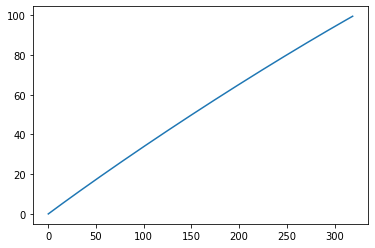

In [20]:
# Finding optimum explained variance

explained_variance = SVD.explained_variance_ratio_
plt.plot(np.cumsum(explained_variance*100))

In [21]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(322, 322)

In [22]:
# # Input values :

# PatientID = 82486
# PatCond = "pc445475"


In [99]:
i = list(ff[ff["_condition"] == str(PatCond)]["_kind"])[0]

Condition_Names = list(X.index)
ConditionIND = Condition_Names.index(i)
correlation_product_ID = correlation_matrix[ConditionIND]

Recommend = list(X.index[correlation_product_ID > np.mean(correlation_product_ID)])

# Removes the condition itself to prevent repeated recommendation
Recommend.remove(i) 

#Recommend[0:4]


def ThID(i):
  return (str(list(Thdf[Thdf["id"] == str(ff[ff["_kind"] == Recommend[i]][["_therapy", "_successful"]].sort_values(by = ["_successful"], ascending = False)["_therapy"].iloc[0])]["id"])[0]))

def ThName(i):
  return (str(list(Thdf[Thdf["id"] == str(ff[ff["_kind"] == Recommend[i]][["_therapy", "_successful"]].sort_values(by = ["_successful"], ascending = False)["_therapy"].iloc[0])]["name"])[0]))


print(" For the entered condition the best recommended therapy is as follows : " + str(list(Thdf[Thdf["id"] == str(ff[ff["_kind"] == Recommend[0]][["_therapy", "_successful"]].sort_values(by = ["_successful"], ascending = False)["_therapy"].iloc[0])]["name"])[0])
)

print("\n\nThe top 5 therapies recommended are : \n"+
      ThName(0) + "( " + ThID(0) + " )\n" +
      ThName(1) + "( " + ThID(1) + " )\n" +
      ThName(2) + "( " + ThID(2) + " )\n" +
      ThName(3) + "( " + ThID(3) + " )\n" 
      )


 For the entered condition the best recommended therapy is as follows : counseling


The top 5 therapies recommended are : 
counseling( Th8 )
chrysotherapy( Th6 )
neurologic music therapy( Th35 )
electromagnetic therapy (alternative medicine)( Th14 )



This was the Collaborative filtering method. We have implemented the model based technique here. The advantage of this method is that given one user's information it considers other similar users data also in order to make a recommendation.